# Examples of generating a request sequence
## - using the WorkloadFit class

Read data 
 * Log data for neuroscience applications
 * Array of past execution times

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st

import WorkloadFit
import OptimalSequence

In [2]:
bins=100

# Log data

`cost_model = WorkloadFit.LogDataCost(data)`

- using the discrete data
- using both interpolation models (polynomial and distribution) to go through a continuous fit
- using distribution interpolation for the checkpoint sequence model

In [14]:
dataset = "ACCRE/dtiQA_v2.out"
data = np.loadtxt(dataset, delimiter=' ')
print("Total entries in the historic data: %d" %(len(data)))

Total entries in the historic data: 5276


In [15]:
wf = WorkloadFit.WorkloadFit(data, bins=bins)
discrete_sequence = wf.compute_discrete_sequence()
print("Discrete sequence: %s" %(discrete_sequence))

Discrete sequence: [(129614.0,), (148864.0,), (172825.0,)]


In [16]:
wf.set_interpolation_model([WorkloadFit.PolyInterpolation(max_order=10),
                            WorkloadFit.DistInterpolation()])
sequence = wf.compute_interpolation_sequence()
print("Best fit sequence: %s" %(sequence))

Best fit sequence: [(112777.054,), (152173.59,), (172825.0,)]


In [17]:
# compute the sequence when checkpoints are taken before the reservation end
wf.change_default_sequence_model(OptimalSequence.CheckpointSequence)
wf.set_interpolation_model([WorkloadFit.DistInterpolation()])
check_sequence = wf.compute_interpolation_sequence()
print("Best fit sequence (with checkpoints): %s" %(check_sequence))

Best fit sequence (with checkpoints): [(91172.502, 1), (10802.276, 0), (31771.4, 0), (59094.804, 0), (81652.498, 0)]


In [18]:
data = [i/3600 for i in data]
sequence = [i[0]/3600 for i in sequence]
discrete_sequence = [i[0]/3600 for i in discrete_sequence]
check_sequence = [(i[0]/3600, i[1]) for i in check_sequence]

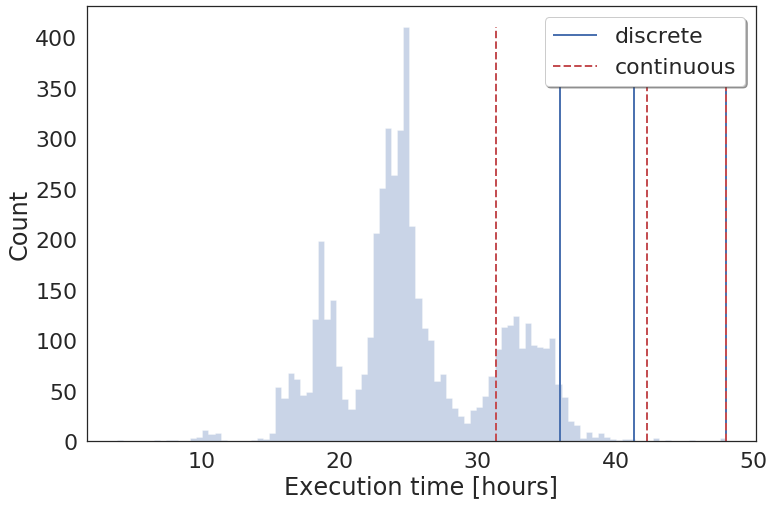

In [20]:
y, x = np.histogram(data, bins=bins)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, histtype='stepfilled', alpha=0.3)

ax.vlines(discrete_sequence[0], min(y), max(y), colors='b', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i], min(y), max(y), colors='b', lw=2, linestyles='solid')

ax.vlines(sequence[0], min(y), max(y), colors='r', linestyles='dashed', lw=2, label='continuous')
for i in range(1,len(sequence)):
    ax.vlines(sequence[i], min(y), max(y), colors='r', linestyles='dashed', lw=2)

ax.legend(shadow=True)
ax.set_xlabel('Execution time [hours]')
ax.set_ylabel('Count')
plt.show()

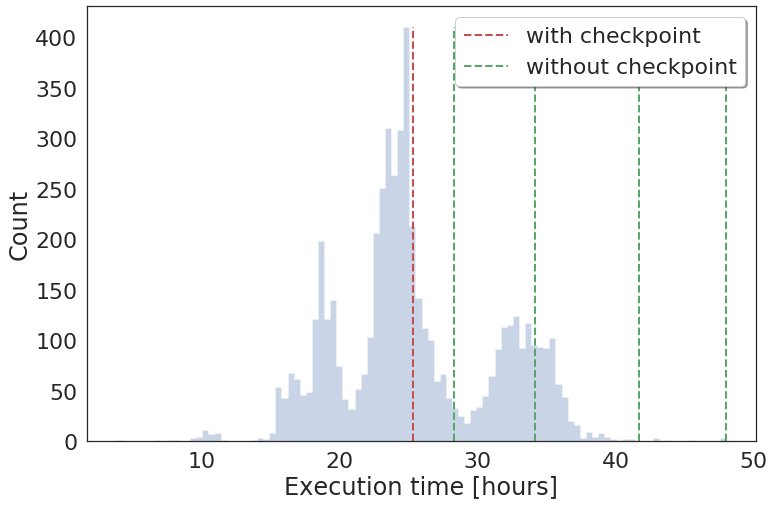

In [21]:
y, x = np.histogram(data, bins=bins)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, histtype='stepfilled', alpha=0.3)

elapsed_time = 0
for i in range(len(check_sequence)):
    col = 'r' if check_sequence[i][1] == 1 else 'g'
    ax.vlines(check_sequence[i][0] + elapsed_time, min(y), max(y), colors=col, linestyles='dashed', lw=2)
    if check_sequence[i][1] == 1:
        elapsed_time += check_sequence[i][0]
    
ax.vlines(min(x), 0, 0, colors='r', linestyles='dashed', lw=2, label='with checkpoint')
ax.vlines(min(x), 0, 0, colors='g', linestyles='dashed', lw=2, label='without checkpoint')

ax.legend(shadow=True)
ax.set_xlabel('Execution time [hours]')
ax.set_ylabel('Count')
plt.show()

# Synthetic workloads

- Generate the data using the normal distribution
- Same workflow as for the neuroscience dataset

In [22]:
bins = 100
distribution = st.truncnorm
lower_limit = 0
upper_limit = 20
mu = 8
sigma = 2
upper_bound = (upper_limit - mu) / sigma
lower_bound = (lower_limit - mu) / sigma

In [23]:
data = distribution.rvs(lower_bound, upper_bound,
                        loc=mu, scale=sigma, size=100)

In [24]:
wf = WorkloadFit.WorkloadFit(data, bins=bins)
discrete_sequence = wf.compute_discrete_sequence()
print("Discrete sequence: %s" %(discrete_sequence))

Discrete sequence: [(10.336081545032345,), (13.381658897729395,)]


In [25]:
wf.set_interpolation_model([WorkloadFit.PolyInterpolation(max_order=10),
                            WorkloadFit.DistInterpolation()])
sequence = wf.compute_interpolation_sequence()
print("Best fit sequence: %s" %(sequence))

Best fit sequence: [(10.322064369331207,), (13.065829785120549,), (13.401398217267447,), (13.381658897729395,)]


In [26]:
# compute the sequence when checkpoints are taken before the reservation end
wf.change_default_sequence_model(OptimalSequence.CheckpointSequence, args=[False, 0.7, 0.7])
wf.set_interpolation_model([WorkloadFit.DistInterpolation()])
check_sequence = wf.compute_interpolation_sequence()
print("Best fit sequence (with checkpoints): %s" %(check_sequence))

Best fit sequence (with checkpoints): [(8.66396152813477, 1), (1.598884882582279, 0), (3.414902280083139, 0), (4.717697369594625, 0)]


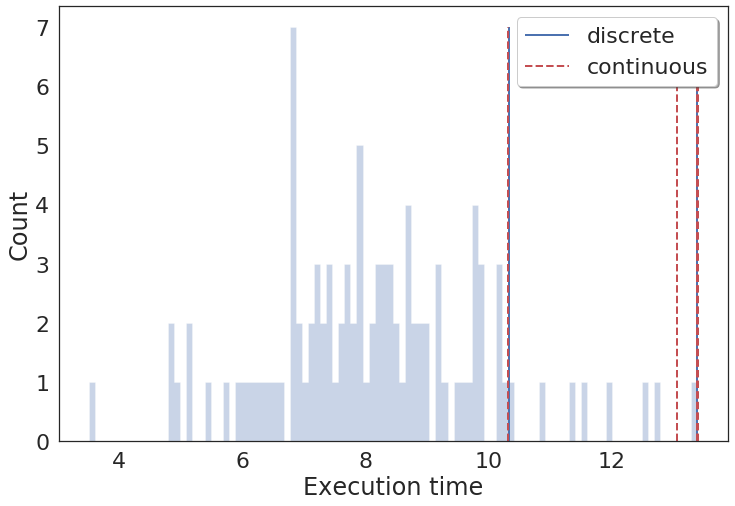

In [27]:
y, x = np.histogram(data, bins=bins) #, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, histtype='stepfilled', alpha=0.3)

ax.vlines(discrete_sequence[0], min(y), max(y), colors='b', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i], min(y), max(y), colors='b', lw=2, linestyles='solid')

ax.vlines(sequence[0], min(y), max(y), colors='r', linestyles='dashed', lw=2, label='continuous')
for i in range(1,len(sequence)):
    ax.vlines(sequence[i], min(y), max(y), colors='r', linestyles='dashed', lw=2)

ax.legend(shadow=True)
ax.set_xlabel('Execution time')
ax.set_ylabel('Count')
plt.show()

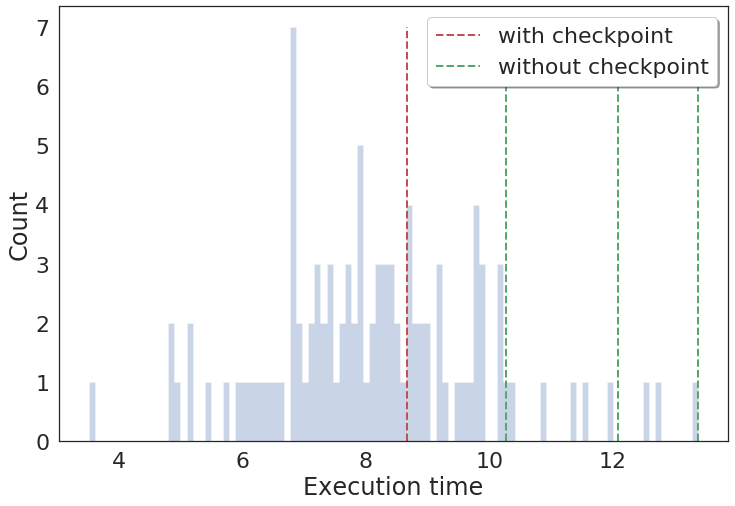

In [28]:
y, x = np.histogram(data, bins=bins)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, histtype='stepfilled', alpha=0.3)

elapsed_time = 0
for i in range(len(check_sequence)):
    col = 'r' if check_sequence[i][1] == 1 else 'g'
    ax.vlines(check_sequence[i][0] + elapsed_time, min(y), max(y), colors=col, linestyles='dashed', lw=2)
    if check_sequence[i][1] == 1:
        elapsed_time += check_sequence[i][0]
    
ax.vlines(min(x), 0, 0, colors='r', linestyles='dashed', lw=2, label='with checkpoint')
ax.vlines(min(x), 0, 0, colors='g', linestyles='dashed', lw=2, label='without checkpoint')

ax.legend(shadow=True)
ax.set_xlabel('Execution time')
ax.set_ylabel('Count')
plt.show()